# Conor Sayres - Final Project
## Analyzing ISO orbits in the Milky Way Potential With Dust
...Imports and constants...

In [1]:
from galpy.potential import MWPotential2014
from galpy.potential import vcirc
from galpy.orbit import Orbit
from astropy import units
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl

cmPerKm = 100000.0
figureCounter = 0

# constants
rho_a = 2.0  # g/cm3 density of asteroid (from paper)
mu = 0.53  # authors vary this parameter (for rocks)
G = 6.67428e-8  # cgs units
C1 = 1.0  # by authors

def savecf():
    # short cut to save figures to disk
    # save current figure
    global figureCounter
    figureCounter += 1
    plt.savefig("fig%i.png"%figureCounter, dpi=250)
    plt.close()

### A function to return dust density for a given R,Z position in the Galaxy

In [2]:
def getDustDensity(R, Z):
    """
    input R and Z in kpc
    calculate dust density at every point in orbit
    scale height and length taken from Li et al
    central density taken from Jones, West and Foster
    returns density in g/cm3 at R,Z in galaxy
    """
    l_o = 3192 / 1000.  # scale length kpc
    rho_o = 47e-26  # g/cm3, West paper central density
    h_o = 103.4 / 1000.  # scale height kpc
    return rho_o * numpy.exp(-R / l_o - numpy.abs(Z) / h_o)

### A function to compute reduction in an ISO's radius
This function is called at each step in the orbit's path to determine the erosion curve for the body.

In [3]:
def sandBlast(initRad, speed, dt, rho_dust):
    """
    inputs:
    initRad: inital asteroid radius (cm)
    speed: relative! speed of asteroid to dust (cm/s)
    dt: time step traveling at speed (s)
    rho_dust: dust density (g/cm3)

    return new asteroid radius in cm (eqn 4 Vavilov)
    """
    asteroidCrossSection = numpy.pi * initRad ** 2
    distanceTraveled = speed * dt
    pathVolume = asteroidCrossSection * distanceTraveled
    massDustEncountered = rho_dust * pathVolume
    asteroidSurfaceArea = 4 * numpy.pi * initRad**2
    mDustPerArea = massDustEncountered / asteroidSurfaceArea

    u = initRad * numpy.sqrt(8 * numpy.pi * G * rho_a / 3.0)
    dR = C1**3 / (2 * numpy.pi) * mDustPerArea / rho_a * (speed / u)**(3 * mu)
    if numpy.isnan(dR):
        # numerically 0 difference
        return initRad, 0
    elif dR > initRad:
        # we've blasted into oblivion
        return 0, 0
    else:
        return initRad - dR, massDustEncountered

### A class to hold the solved orbit, provides a simple plotting routine to display results.

In [4]:
class SolvedOrbit(object):
    def __init__(self, ts, R, vR, vT, Z, vZ, phi, asteroidRad, relativeVel, rho_dust):
        """
        inputs (all arrays):
        ts - timeseries (Gyr)
        R - orbit radius in kpc
        vR - orbit radial velocity in km/s
        vT - oribit tangental velocity in km/s
        Z - orbit Z position in kpc
        vZ - orbit Z velocity in km/s
        phi - orbit phi position in degrees
        asteroidRad - asteroid radii in cm
        relativeVel - relative velocity between dust and astroid in km/s
        rho_dust - density of dust g/cm3
        """
        self.ts = ts
        self.R = R
        self.vR = vR
        self.vT = vT
        self.Z = Z
        self.vZ = vZ
        self.phi = phi
        self.asteroidRad = asteroidRad
        self.relativeVel = relativeVel
        self.rho_dust = rho_dust

    def makePlots(self):
        rlist = numpy.linspace(min(so.R), max(so.R), 500)
        zlist = numpy.linspace(min(so.Z), max(so.Z), 500)
        rGrid, zGrid = numpy.meshgrid(rlist, zlist)
        dList = getDustDensity(rGrid, zGrid)

        cp = plt.contourf(rlist, zlist, dList, levels=20)
        plt.colorbar(cp, label="Dust Density ($g/cm^{3}$)")
        plt.plot(so.R, so.Z, color='cyan', linewidth=0.5, alpha=0.9, label="modeled orbit (%.0f Gyr)"%so.ts[-1].value)
        plt.xlabel("R (kpc)")
        plt.ylabel("Z (kpc)")
        plt.legend(loc=2, framealpha=1)
        savecf()

        fig, ax = plt.subplots(3,1, figsize=(6,10))
        ax[0].plot(so.ts, so.relativeVel, alpha=0.7, color='black')
        ax[0].set_ylabel("relative dust velocity (km/s)")

        ax[1].plot(so.ts, so.rho_dust, alpha=0.7, color='black')
        ax[1].set_ylabel("dust density (g/cm$^{3}$)")

        ax[2].plot(so.ts, so.asteroidRad / 100, alpha=0.8, color='black')
        ax[2].set_ylabel("asteroid radius (m)")
        ax[2].set_xlabel("time (Gyr)")
        savecf()

    def printInitCond(self):
        print("asteroidRad=%.2f(m) vR=%.2f(km/s) vT=%.2f(km/s) vZ=%.2f(km/s)" % (
            self.asteroidRad[0] / 100,
            self.vR[0],
            self.vT[0],
            self.vZ[0]
            ))

### A routine to run an orbit integration with various initial conditions as arguments.

In [5]:
def runMWOrbit(duration, nSteps, ivR, ivT, ivZ, iRad):
    """ simulate a particle in the MW's potential including dust blasting
    orbit begins at R=1, Z=0, phi=0 (galpy's natural units)
    the potential is scaled to have circular velocity of 220.0 km/s
    at 8 kpc

    inputs:
    duration - time (Gyr)
    nSteps - number of steps to save
    ivT - initial tangental velocity (natural units)
    ivR - inital radial velocity (natural units)
    ivZ - inital vertical velocity (natural units)
    iRad - initial radius of asteroid (cm)

    returns: a SolvedOribit
    """

    # MW circ velocity is 220 km/s at 8 kpc
    ro = 8.0  # kpc
    vo = 220.0  # km/s
    # spectify time points for integration
    ts = numpy.linspace(0, duration, nSteps) * units.Gyr  # timeseries for integration
    # determine the time step in seconds
    dt = float(numpy.diff(ts)[0].to(units.second).value)

    # initial conditions for orbit
    # in galpy's natural units (to be scaled by ro/vo)
    iR = 1.  # inital radius
    iZ = 0.  # initial Z
    iphi = 0.  # initial phi

    # run the orbit
    vxvv = [iR, ivR, ivT, iZ, ivZ, iphi]
    op = Orbit(vxvv=vxvv, ro=ro, vo=vo)  # Use Vc=220 km/s at R= 8 kpc
    op.integrate(ts, MWPotential2014)
    R, vR, vT, Z, vZ, phi = op.getOrbit().T

    # for every R, calculate the circular velocity
    # we assume this is the speed at which dust is moving
    # and that it has no vertical nor radial component
    vT_Dust = vcirc(MWPotential2014, R)

    # get relative velcity between asteroid and dust
    # for every point in orbit in km/s
    relativeVel = numpy.linalg.norm(numpy.array([vR, vT - vT_Dust, vZ]), axis=0) * vo

    # for every R,Z get the density of dust
    # must be in units of kpc hence the ro scaling
    rho_dust = getDustDensity(R * ro, Z * ro)

    asteroidRad = [iRad]
    # step through every point in orbit, and compute
    # new asteroid radius due to sandblasting
    # eveluate everything at enpoint of integration step
    # so skip the first (0th) step
    for i in range(1, nSteps):
        # calculate relative dust speed in cm/s
        newRad, massDustEncountered = sandBlast(asteroidRad[-1], relativeVel[i] * cmPerKm, dt, rho_dust[i])
        asteroidRad.append(newRad)

    return SolvedOrbit(ts, R*ro, vR*vo, vT*vo, Z*ro, vZ*vo, numpy.degrees(phi), numpy.asarray(asteroidRad), relativeVel, rho_dust)

### A similar function to compute a similar oribt, except with the addition of a damping force experienced due to dust collisions.

In [6]:
def runDampedMWOrbit(duration, nSteps, ivR, ivT, ivZ, iRad):
    """ simulate a particle in the MW's potential including dust blasting
    and damping! orbit begins at R=1, Z=0, phi=0 (galpy's natural units)
    the potential is scaled to have circular velocity of 220.0 km/s
    at 8 kpc

    inputs:
    duration - time (Gyr)
    nSteps - number of steps to save
    ivT - initial tangental velocity (natural units)
    ivR - inital radial velocity (natural units)
    ivZ - inital vertical velocity (natural units)
    iRad - initial radius of asteroid (cm)

    returns: a SolvedOribit
    """

    # MW circ velocity is 220 km/s at 8 kpc
    ro = 8.0  # kpc
    vo = 220.0  # km/s
    # spectify time points for integration
    ts = numpy.linspace(0, duration, nSteps) * units.Gyr  # timeseries for integration
    # determine the time step in seconds
    dt = float(numpy.diff(ts)[0].to(units.second).value)

    # initial conditions for orbit
    # in galpy's natural units (to be scaled by ro/vo)
    iR = 1.  # inital radius
    iZ = 0.  # initial Z
    iphi = 0.  # initial phi

    # we will stepwise populate these
    R = [iR]
    vR = [ivR]
    vT = [ivT]
    Z = [iZ]
    vZ = [ivZ]
    asteroidRad = [iRad]

    vT_Dust = vcirc(MWPotential2014, iR)
    relativeVel = [numpy.linalg.norm(numpy.array([ivR, ivT - vT_Dust, ivZ])) * vo]
    rho_dust = [getDustDensity(iR * ro, iZ * ro)]

    for tt in ts[:-1]:
        # run the orbit stepwise and adjust kinematics
        # due to collisions
        vxvv = [R[-1], vR[-1], vT[-1], Z[-1], vZ[-1]]
        op = Orbit(vxvv=vxvv, ro=ro, vo=vo)  # Use Vc=220 km/s at R= 8 kpc
        op.integrate(ts[:2], MWPotential2014)
        dR, dvR, dvT, dZ, dvZ = op.getOrbit().T

        nextR = dR[-1]
        nextvR = dvR[-1]
        nextvT = dvT[-1]
        nextZ = dZ[-1]
        nextvZ = dvZ[-1]

        vT_Dust = vcirc(MWPotential2014, nextR)
        relativeVel.append(numpy.linalg.norm(numpy.array([nextvR, nextvT - vT_Dust, nextvZ])) * vo)
        rho_dust.append(getDustDensity(nextR * ro, nextZ * ro))
        aRad = asteroidRad[-1]
        newRad, massDustEncountered = sandBlast(aRad, relativeVel[-1] * cmPerKm, dt, rho_dust[-1])
        if massDustEncountered > 0:
            # calculate collision and adjust
            asteroidMass = 4/3*numpy.pi*aRad**3 * rho_a
            # eqn for elastic collision (assume all dust mass = a single impulse)
            vAsteroidOut = (asteroidMass - massDustEncountered)/(asteroidMass+massDustEncountered) * relativeVel[-1]
            scaleFac = vAsteroidOut / relativeVel[-1]
            nextvR *= scaleFac
            nextvT = (nextvT-vT_Dust)*scaleFac + vT_Dust
            nextvZ *= scaleFac

        asteroidRad.append(newRad)
        R.append(nextR)
        vR.append(nextvR)
        vT.append(nextvT)
        Z.append(nextZ)
        vZ.append(nextvZ)

    R = numpy.asarray(R)
    vR = numpy.asarray(vR)
    vT = numpy.asarray(vT)
    Z = numpy.asarray(Z)
    vZ = numpy.asarray(vZ)
    relativeVel = numpy.asarray(relativeVel)
    rho_dust = numpy.asarray(rho_dust)
    phi = numpy.zeros(len(R))

    return SolvedOrbit(ts, R*ro, vR*vo, vT*vo, Z*ro, vZ*vo, numpy.degrees(phi), numpy.asarray(asteroidRad), relativeVel, rho_dust)

### A function to overplot damped and undamped orbit solutions

In [7]:
def jointOrbitPlot(damped, undamped, save=True):
    maxR = max([max(damped.R), max(undamped.R)])
    minR = min([min(damped.R), min(undamped.R)])

    maxZ = max([max(damped.Z), max(undamped.Z)])
    minZ = min([min(damped.Z), min(undamped.Z)])

    rlist = numpy.linspace(minR, maxR, 500)
    zlist = numpy.linspace(minZ, maxZ, 500)
    rGrid, zGrid = numpy.meshgrid(rlist, zlist)
    dList = getDustDensity(rGrid, zGrid)

    tEnd = damped.ts[-1].value
    plt.figure(figsize=(10,10))
    cp = plt.contourf(rlist, zlist, dList, levels=20)
    plt.colorbar(cp, label="Dust Density ($g/cm^{3}$)")
    plt.plot(undamped.R, undamped.Z, color='cyan', linewidth=0.5, alpha=0.9, label="undamped orbit (%.0f Gyr)"%tEnd)
    plt.plot(damped.R, damped.Z, color='black', linestyle=":", linewidth=0.5, alpha=0.9, label="damped orbit (%.0f Gyr)"%tEnd)
    plt.xlabel("R (kpc)")
    plt.ylabel("Z (kpc)")
    plt.legend(loc=2, framealpha=1)
    if save:
        savecf()

    plt.figure(figsize=(10,10))
    plt.plot(undamped.ts, undamped.asteroidRad / 100, linewidth=2, color="black", label="undamped")
    plt.plot(damped.ts, undamped.asteroidRad / 100, linestyle=":", color='cyan', label="damped")
    plt.legend()
    plt.xlabel("time (Gyr)")
    plt.ylabel("asteroid radius (m)")
    if save:
        savecf()

### Here I display an example over-plotting two equivalant orbits (one damped, one not).

/Users/csayres/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()

/Users/csayres/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars



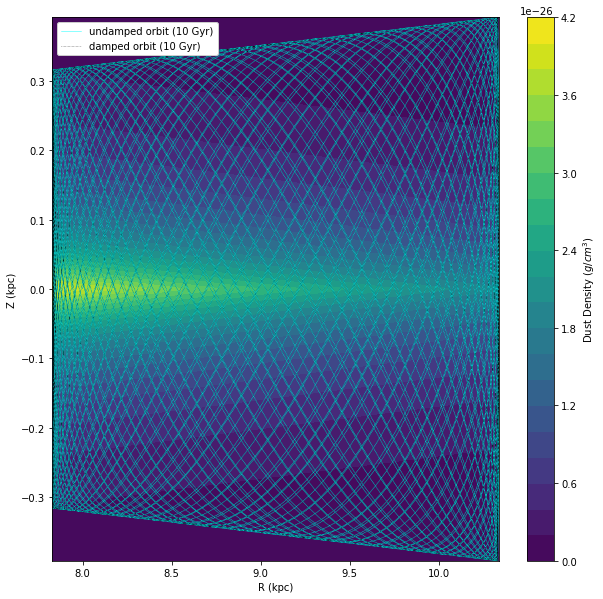

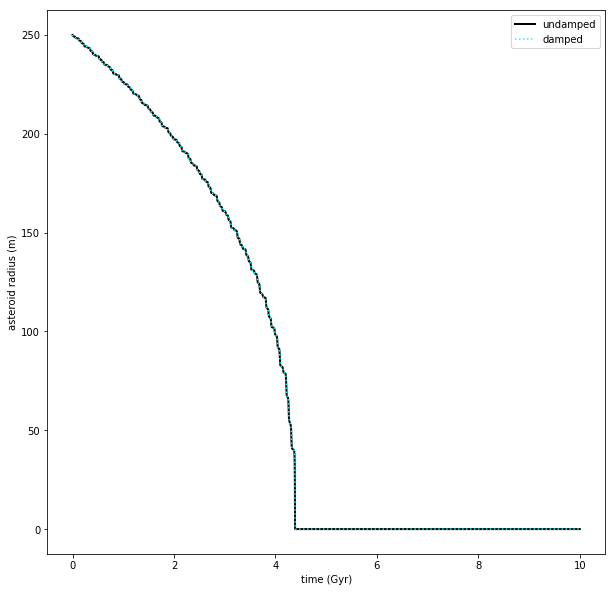

In [8]:
duration = 10 # Gyr
nSteps = 100000 
vR = 0.1 # galpy natural units
vT = 1.1 # galpy natural units
vZ = 0.1 # galpy natural units
asteroidRadius = 250 # meters
dso = runDampedMWOrbit(duration, nSteps, vR, vT, vZ, asteroidRadius*100)
so = runMWOrbit(duration, nSteps, vR, vT, vZ, asteroidRadius*100)
jointOrbitPlot(dso, so, save=False)
plt.show();

### The following will generate all the plots in the report and save them to disk.

In [9]:
def plotRadVsTimeSet(soList):
    for so in soList:
        plt.plot(so.ts, so.asteroidRad / 100.0)
    plt.xlabel("time (Gyr)")
    plt.ylabel("asteroid radius (m)")
    savecf()

astRad = 250 # meters
so = runMWOrbit(10, 100000, 0.1, 1.1, 0.1, astRad*100)
so.makePlots()
so.printInitCond()

# give large Z component velocity?

so = runMWOrbit(10, 100000, 0.1, 1.1, 0.5, astRad*100)
print("larg z ", figureCounter)
so.makePlots()

so.printInitCond()

# give large T component velocity?

so = runMWOrbit(10, 100000, 0.1, 1.7, 0.5, astRad*100)
print("larg T ", figureCounter)
so.makePlots()
so.printInitCond()

# near circular

so = runMWOrbit(10, 100000, 0.05, 1.05, 0.05, astRad*100)
print("circ ", figureCounter)
so.makePlots()
so.printInitCond()

# plot range of asteroid sizes
soList = []
for rad in 10**numpy.linspace(1, 3, 20):
    soList.append(runMWOrbit(10, 100000, 0.1, 1.1, 0.1, rad * 100))
soList[0].printInitCond()

plotRadVsTimeSet(soList)

print("damped", figureCounter)
dso = runDampedMWOrbit(10, 100000, 0.1, 1.1, 0.1, astRad*100)
so = runMWOrbit(10, 100000, 0.1, 1.1, 0.1, astRad*100)
so.printInitCond()

jointOrbitPlot(dso, so)

# high z
dso = runDampedMWOrbit(10, 100000, 0.1, 1.1, 0.5, astRad*100)
so = runMWOrbit(10, 100000, 0.1, 1.1, 0.5, astRad*100)
so.printInitCond()

jointOrbitPlot(dso, so)

/Users/csayres/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()

/Users/csayres/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars

asteroidRad=250.00(m) vR=22.00(km/s) vT=242.00(km/s) vZ=22.00(km/s)
larg z  2
asteroidRad=250.00(m) vR=22.00(km/s) vT=242.00(km/s) vZ=110.00(km/s)
larg T  4
asteroidRad=250.00(m) vR=22.00(km/s) vT=374.00(km/s) vZ=110.00(km/s)
circ  6
asteroidRad=250.00(m) vR=11.00(km/s) vT=231.00(km/s) vZ=11.00(km/s)
asteroidRad=10.00(m) vR=22.00(km/s) vT=242.00(km/s) vZ=22.00(km/s)
damped 9
asteroidRad=250.00(m) vR=22.00(km/s) vT=242.00(km/s) vZ=22.00(km/s)
asteroidRad=250.00(m) vR=22.00(km/s) vT=242.00(km/s) vZ=110.00(km/s)
